## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'approx1e5-spaceNet-fourier-gray' # Dataset Format: size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\spaceNet\\fourier\\approx1e5\\gray'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 47614,
 3: 54416,
 4: 61218,
 5: 102030,
 6: 156446,
 7: 197258,
 8: 326496,
 9: 421724,
 10: 639388,
 11: 904666,
 12: 1312786,
 13: 1904560,
 14: 2727602,
 15: 3958764,
 16: 5720482,
 17: 8298440,
 18: 11957916,
 19: 17270278,
 20: 25140192,
 21: 36322680,
 22: 52586262,
 23: 65734528,
 24: 32003410}

c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta

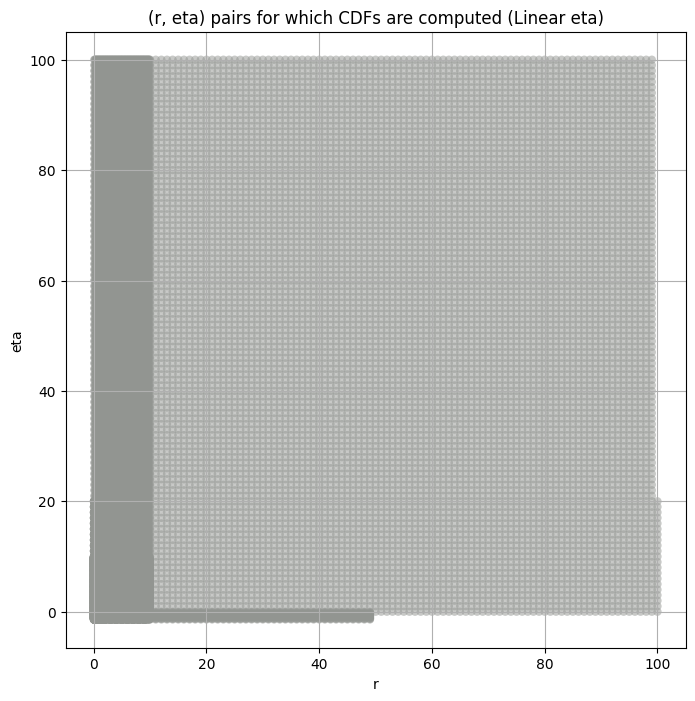

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


In [5]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  1%|          | 506/100000 [00:00<00:19, 5009.87it/s]

100%|██████████| 100000/100000 [01:03<00:00, 1576.75it/s]


Band 5


100%|██████████| 100000/100000 [00:59<00:00, 1672.14it/s]


Band 8


100%|██████████| 100000/100000 [00:59<00:00, 1669.75it/s]


Band 11


100%|██████████| 100000/100000 [00:59<00:00, 1673.65it/s]


Band 14


100%|██████████| 100000/100000 [01:02<00:00, 1602.52it/s]


Band 17


100%|██████████| 100000/100000 [01:09<00:00, 1440.55it/s]


Band 20


100%|██████████| 100000/100000 [01:57<00:00, 850.42it/s]


Band 23


100%|██████████| 100000/100000 [02:10<00:00, 765.02it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,2.108037e+08,1.960605e+08,2.266248e+08,5.938156,4.311651,8.405163,47614.0
5,8.466665e+07,7.748904e+07,9.283818e+07,10.238721,6.227642,16.210068,102030.0
8,2.441800e+07,2.231098e+07,2.684011e+07,10.654583,6.318540,24.114672,326496.0
11,6.095848e+06,5.591611e+06,6.651503e+06,9.481830,6.036284,16.780165,904666.0
14,1.795079e+06,1.641329e+06,1.980499e+06,11.123091,6.303249,29.718306,2727602.0
17,4.415782e+05,3.955819e+05,5.499408e+05,38.040100,6.955561,230.069320,8298440.0
20,7.319305e+04,6.264591e+04,1.226981e+05,212.946900,7.135597,983.588700,25140192.0
23,1.741782e+04,1.578904e+04,2.204838e+04,38.076736,4.879169,234.753980,65734528.0


## Initial Grid Search and Hypothesis Test Plots

####
Band  2


  0%|          | 37/55966 [00:00<05:09, 180.56it/s]

100%|██████████| 55966/55966 [05:08<00:00, 181.42it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 47614, Without approximation : 47614.0


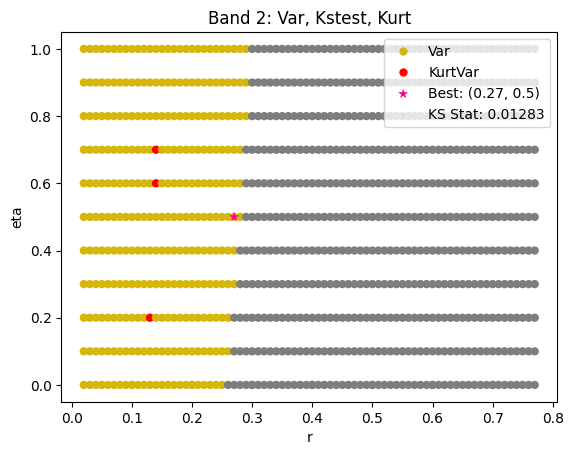

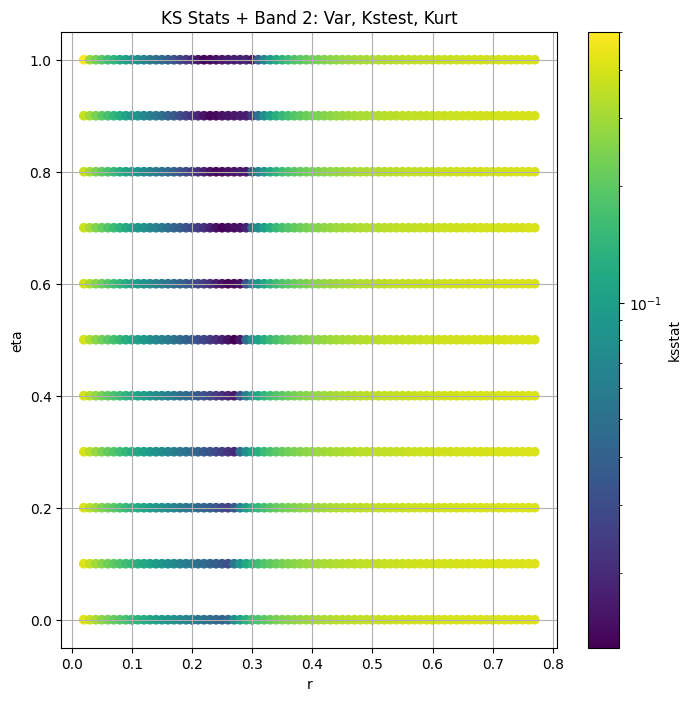

####
Band  5


100%|██████████| 55966/55966 [10:26<00:00, 89.37it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 102030.0


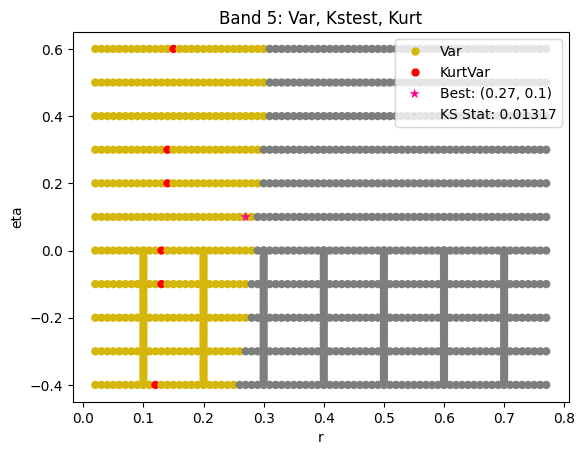

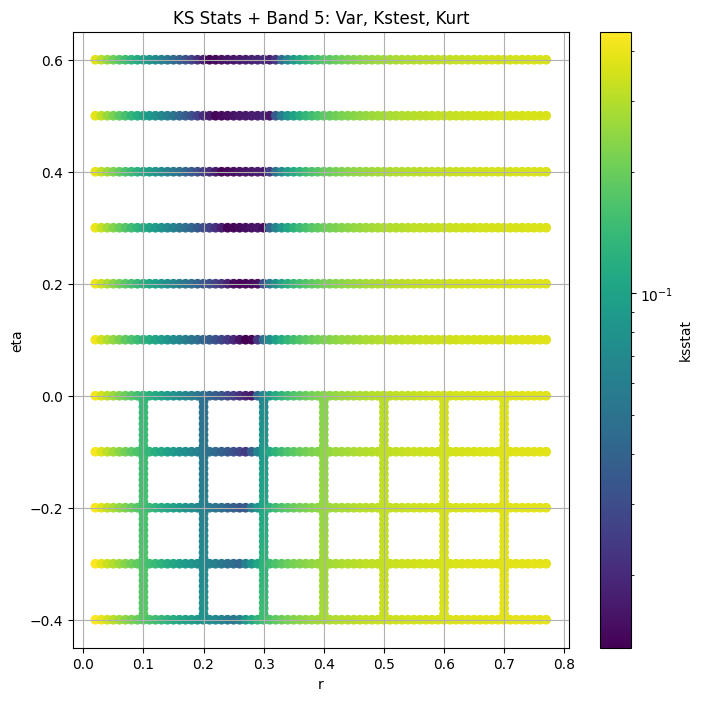

####
Band  8


100%|██████████| 55966/55966 [11:01<00:00, 84.63it/s]  


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 326496.0


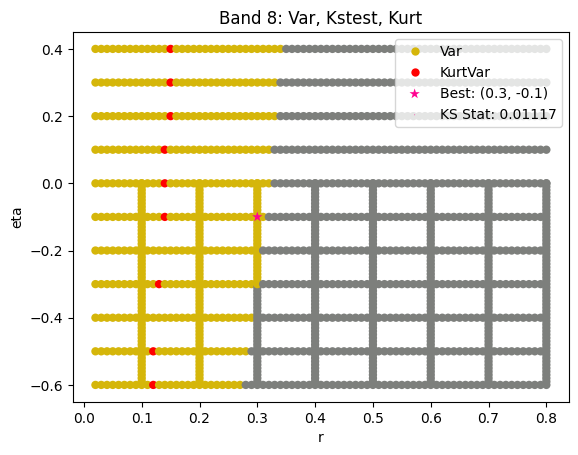

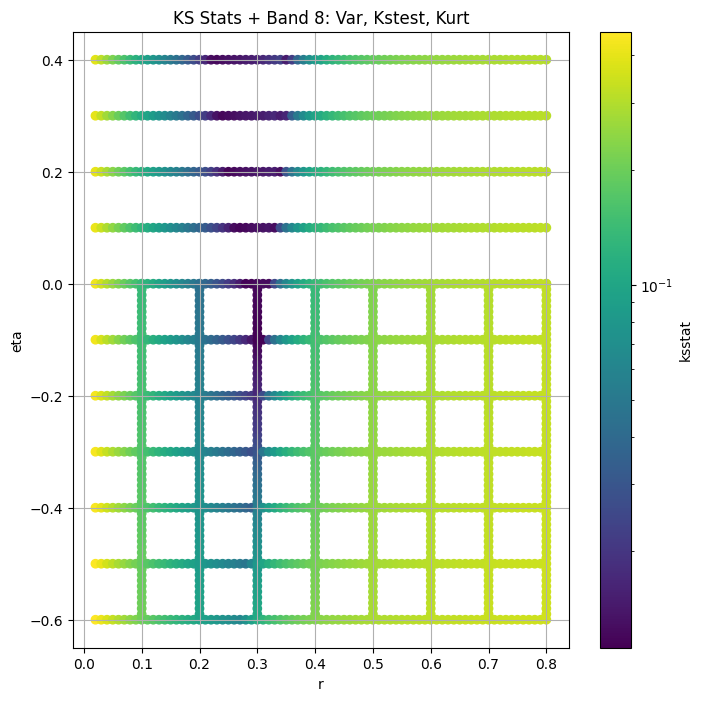

####
Band  11


100%|██████████| 55966/55966 [11:06<00:00, 83.94it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 904666.0


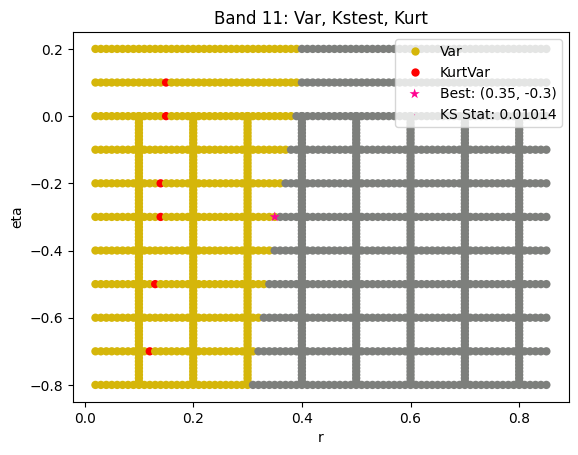

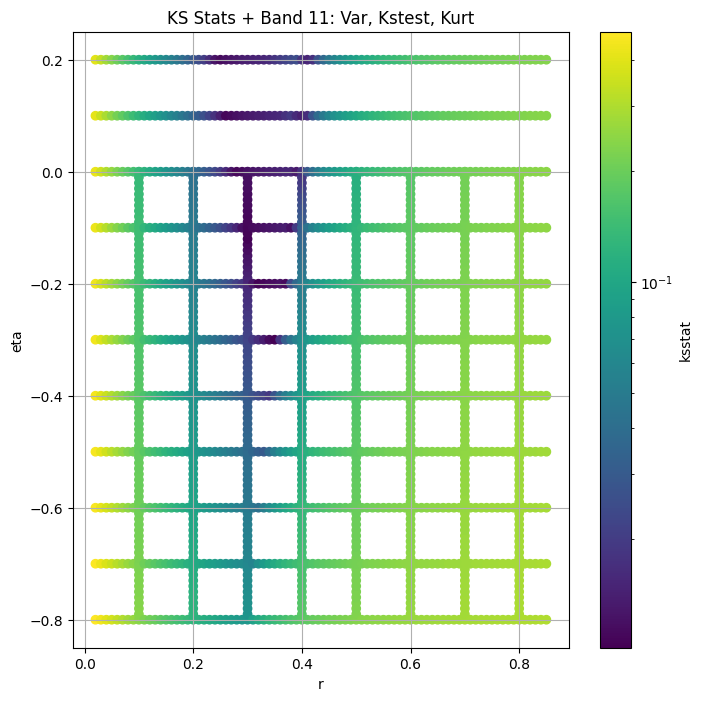

####
Band  14


100%|██████████| 55966/55966 [12:33<00:00, 74.28it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 2727602.0


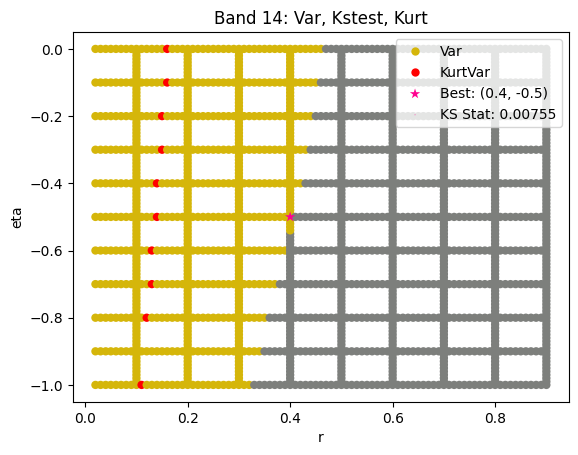

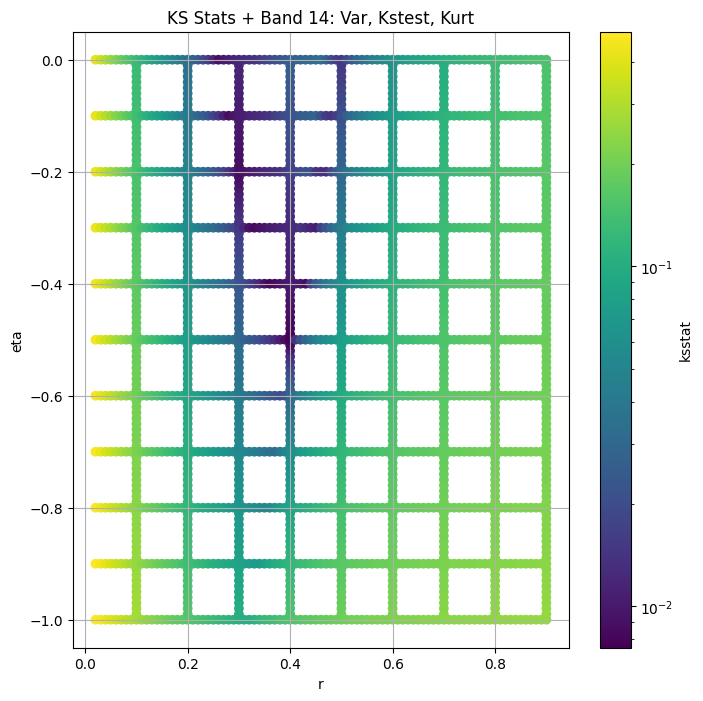

####
Band  17


100%|██████████| 55966/55966 [10:23<00:00, 89.72it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 8298440.0


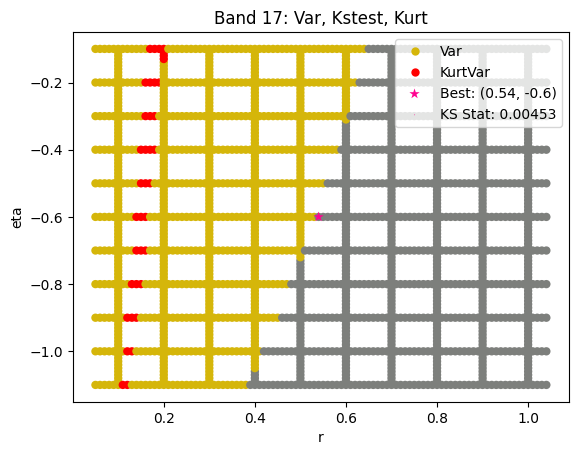

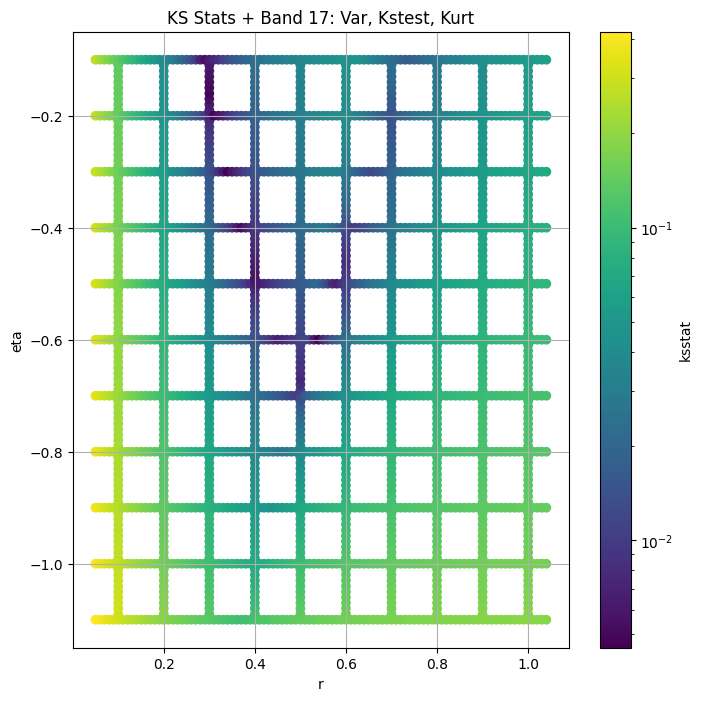

####
Band  20


100%|██████████| 55966/55966 [10:39<00:00, 87.46it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 25140192.0


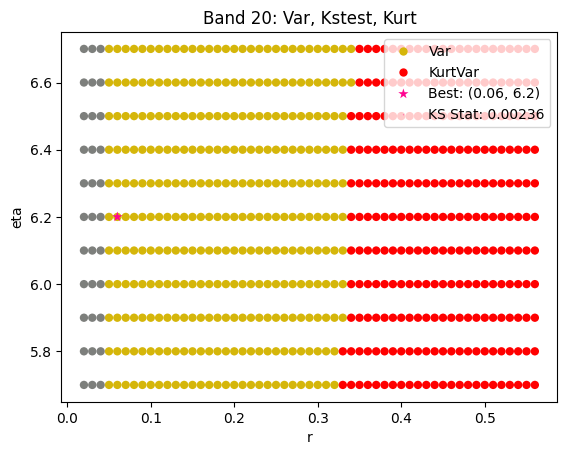

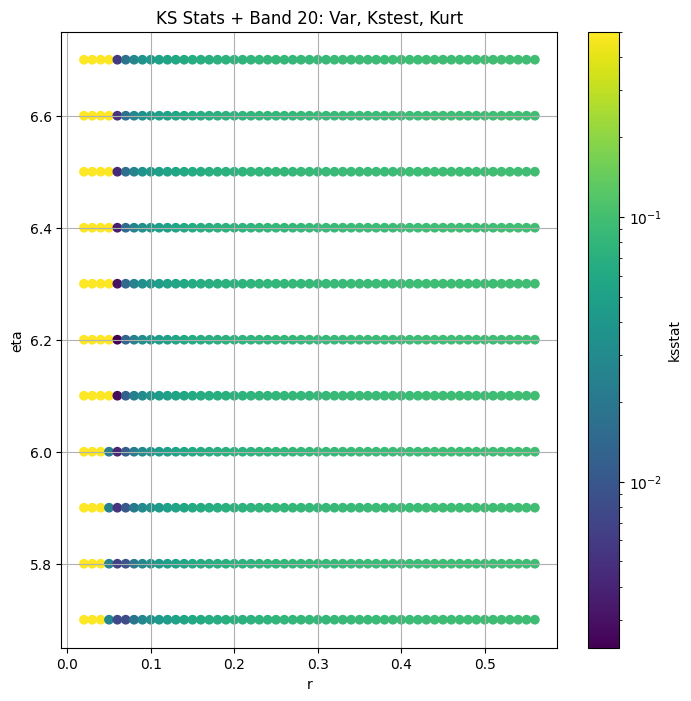

####
Band  23


100%|██████████| 55966/55966 [10:27<00:00, 89.12it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 65734528.0


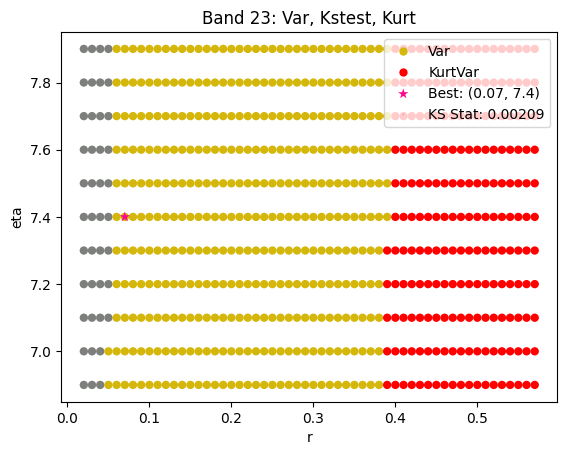

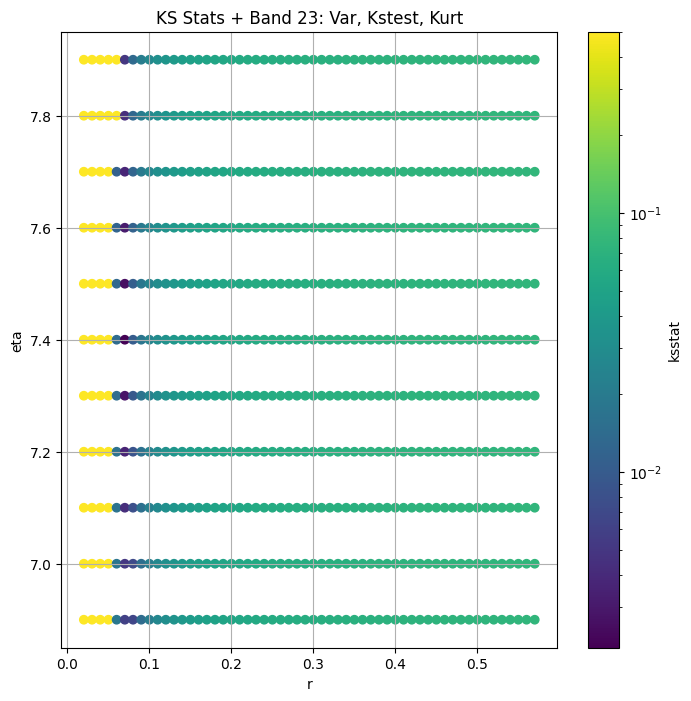

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,initial_scale,kstest_stat_initial,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,
2,2.108037e+08,1.960605e+08,2.266248e+08,5.938156,4.311651,8.405163,47614.0,0.27,0.5,6.990252e+04,0.012831,0.006220
5,8.466665e+07,7.748904e+07,9.283818e+07,10.238721,6.227642,16.210068,102030.0,0.27,0.1,5.642633e+04,0.013172,0.004250
8,2.441800e+07,2.231098e+07,2.684011e+07,10.654583,6.318540,24.114672,326496.0,0.30,-0.1,7.127441e+04,0.011174,0.002376
11,6.095848e+06,5.591611e+06,6.651503e+06,9.481830,6.036284,16.780165,904666.0,0.35,-0.3,9.521702e+04,0.010139,0.001428
14,1.795079e+06,1.641329e+06,1.980499e+06,11.123091,6.303249,29.718306,2727602.0,0.40,-0.5,9.942795e+04,0.007551,0.000822
17,4.415782e+05,3.955819e+05,5.499408e+05,38.040100,6.955561,230.069320,8298440.0,0.54,-0.6,1.000000e+05,0.004529,0.000471
20,7.319305e+04,6.264591e+04,1.226981e+05,212.946900,7.135597,983.588700,25140192.0,0.06,6.2,2.000461e-31,0.002360,0.000271
23,1.741782e+04,1.578904e+04,2.204838e+04,38.076736,4.879169,234.753980,65734528.0,0.07,7.4,7.356095e-27,0.002091,0.000168


In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = initial_param,
                            best_ksstat=min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:01<00:00, 190.23it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:04<00:00, 91.04it/s] 


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 98.94it/s] 


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 103.18it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 100.03it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 98.02it/s] 


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:06<00:00, 61.02it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:04<00:00, 87.73it/s] 

Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,initial_scale,kstest_stat_initial,kstest_stat_cutoff_0.05,best_r_eta0,best_scale_eta0,kstest_stat_eta0
band,,,,,,,,,,,,,,,
2,2.108037e+08,1.960605e+08,2.266248e+08,5.938156,4.311651,8.405163,47614.0,0.27,0.5,6.990252e+04,0.012831,0.006220,0.36,199.297316,0.259215
5,8.466665e+07,7.748904e+07,9.283818e+07,10.238721,6.227642,16.210068,102030.0,0.27,0.1,5.642633e+04,0.013172,0.004250,0.36,199.297316,0.182346
8,2.441800e+07,2.231098e+07,2.684011e+07,10.654583,6.318540,24.114672,326496.0,0.30,-0.1,7.127441e+04,0.011174,0.002376,0.36,199.297316,0.078819
11,6.095848e+06,5.591611e+06,6.651503e+06,9.481830,6.036284,16.780165,904666.0,0.35,-0.3,9.521702e+04,0.010139,0.001428,0.39,352.424126,0.013293
14,1.795079e+06,1.641329e+06,1.980499e+06,11.123091,6.303249,29.718306,2727602.0,0.40,-0.5,9.942795e+04,0.007551,0.000822,0.50,1451.484833,0.014847
17,4.415782e+05,3.955819e+05,5.499408e+05,38.040100,6.955561,230.069320,8298440.0,0.54,-0.6,1.000000e+05,0.004529,0.000471,0.78,6933.601867,0.019370
20,7.319305e+04,6.264591e+04,1.226981e+05,212.946900,7.135597,983.588700,25140192.0,0.06,6.2,2.000461e-31,0.002360,0.000271,6.00,29682.030508,0.070616
23,1.741782e+04,1.578904e+04,2.204838e+04,38.076736,4.879169,234.753980,65734528.0,0.07,7.4,7.356095e-27,0.002091,0.000168,6.00,29682.030508,0.175992


## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Band 2


(0.262, 0.49), 50 of 420
(0.264, 0.59), 100 of 420
(0.267, 0.49), 150 of 420
(0.269, 0.59), 200 of 420
(0.272, 0.49), 250 of 420
(0.274, 0.59), 300 of 420
(0.277, 0.49), 350 of 420
(0.279, 0.59), 400 of 420


100%|██████████| 420/420 [00:02<00:00, 179.08it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 2 best parameters: ((0.274, 0.47), 0.012796379596323848)


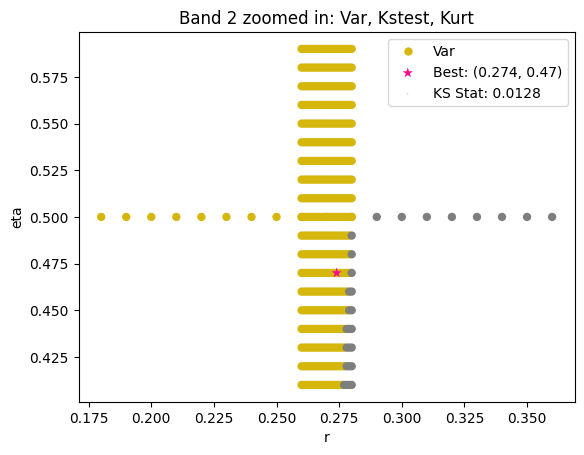

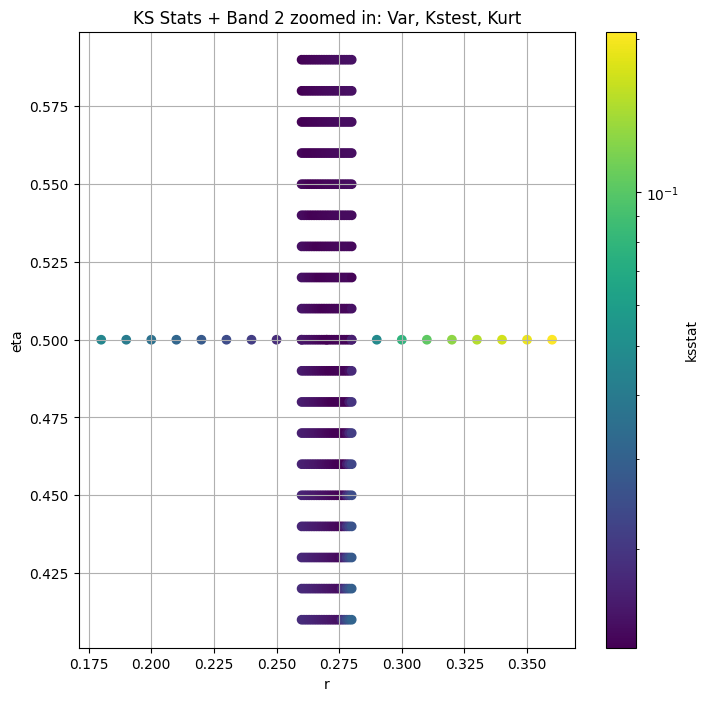

Band 5
(0.262, 0.09), 50 of 420
(0.264, 0.19), 100 of 420
(0.267, 0.09), 150 of 420
(0.269, 0.19), 200 of 420
(0.272, 0.09), 250 of 420
(0.274, 0.19), 300 of 420
(0.277, 0.09), 350 of 420
(0.279, 0.19), 400 of 420


100%|██████████| 420/420 [00:04<00:00, 92.35it/s] 


Finding Minimum after computing 420 CDFs
Iter 1 band 5 best parameters: ((0.28, 0.04), 0.013075314372351932)


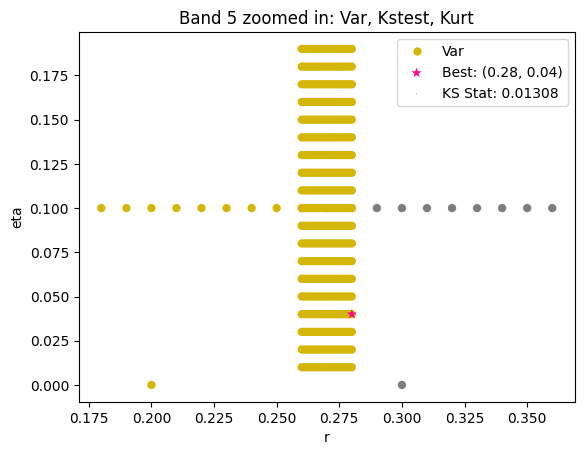

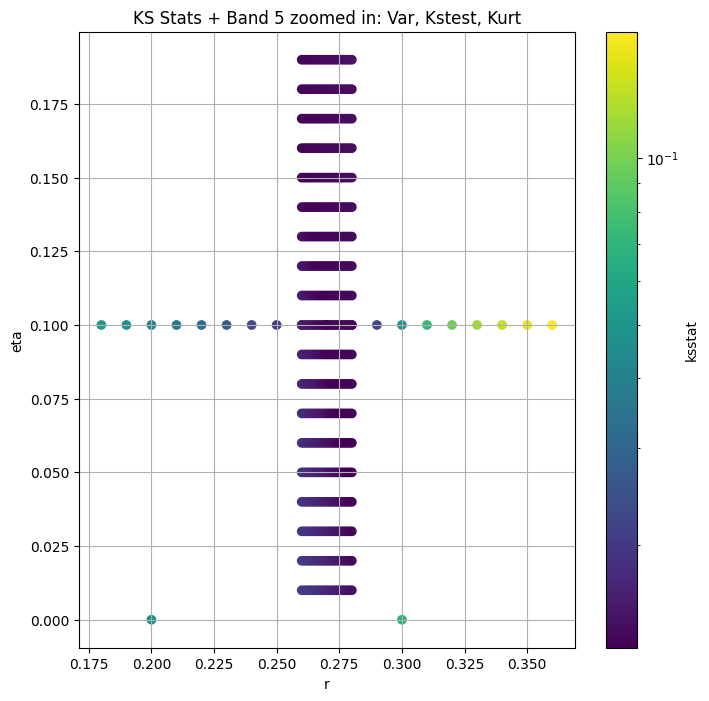

Band 8
(0.292, -0.101), 50 of 420
(0.294, -0.091), 100 of 420
(0.297, -0.101), 150 of 420
(0.299, -0.091), 200 of 420
(0.302, -0.101), 250 of 420
(0.304, -0.091), 300 of 420
(0.307, -0.101), 350 of 420
(0.309, -0.091), 400 of 420


100%|██████████| 420/420 [00:04<00:00, 91.40it/s] 


Finding Minimum after computing 420 CDFs
Iter 1 band 8 best parameters: ((0.302, -0.108), 0.011088190301872358)


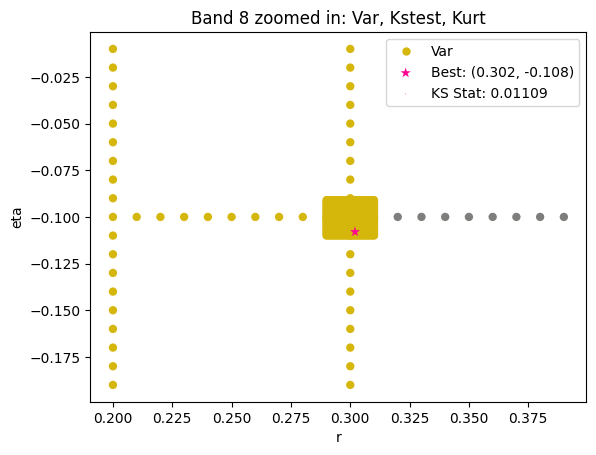

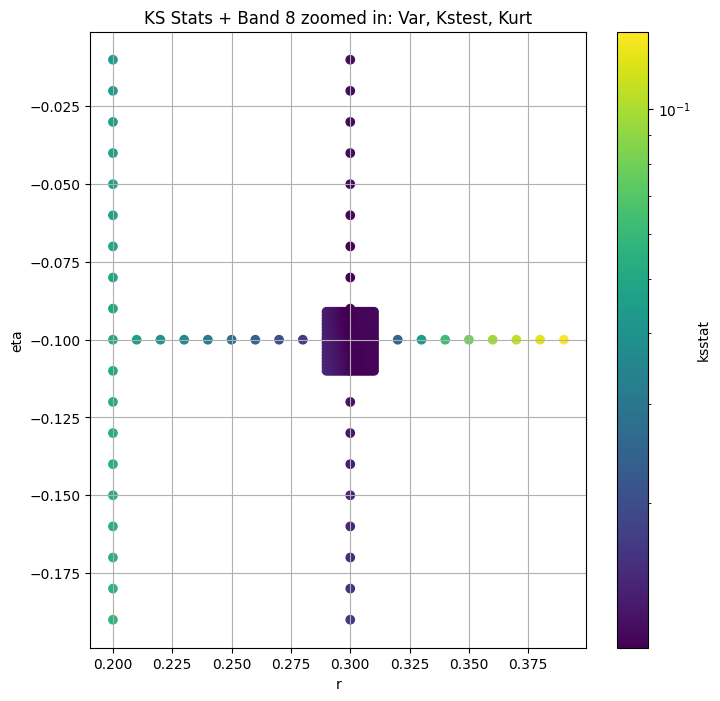

Band 11
(0.342, -0.33), 50 of 441
(0.344, -0.25), 100 of 441
(0.347, -0.38), 150 of 441
(0.349, -0.3), 200 of 441
(0.351, -0.22), 250 of 441
(0.354, -0.35), 300 of 441
(0.356, -0.27), 350 of 441
(0.359, -0.4), 400 of 441


100%|██████████| 441/441 [00:05<00:00, 79.31it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 11 best parameters: ((0.349, -0.31), 0.009938246289265096)


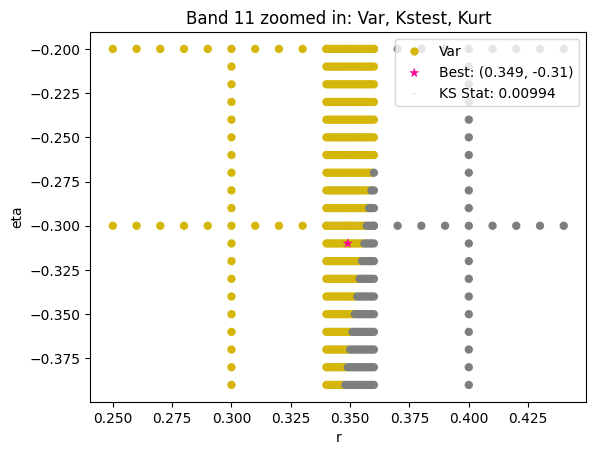

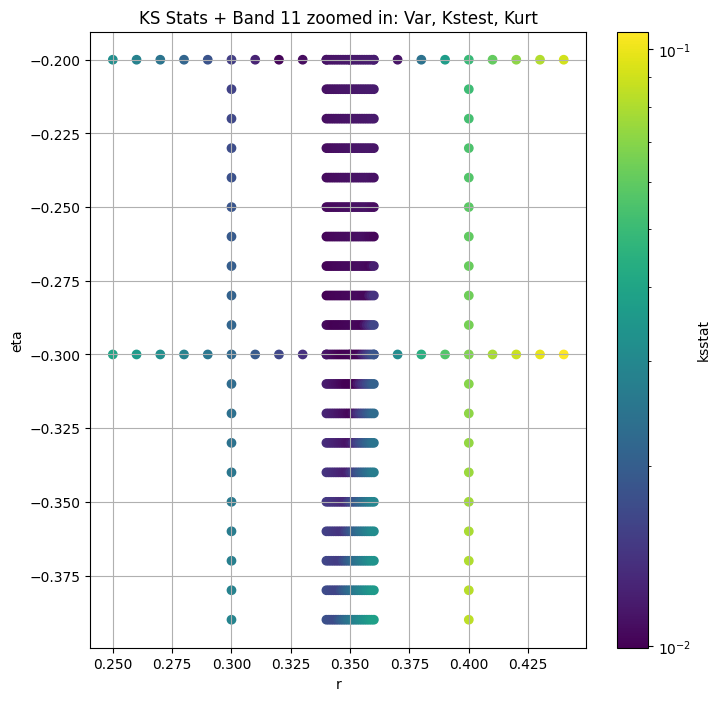

Band 14
(0.392, -0.503), 50 of 441
(0.394, -0.495), 100 of 441
(0.397, -0.508), 150 of 441
(0.399, -0.5), 200 of 441
(0.401, -0.492), 250 of 441
(0.404, -0.505), 300 of 441
(0.406, -0.497), 350 of 441
(0.409, -0.51), 400 of 441


100%|██████████| 441/441 [00:04<00:00, 91.58it/s] 


Finding Minimum after computing 441 CDFs
Iter 1 band 14 best parameters: ((0.399, -0.506), 0.007354659058991353)


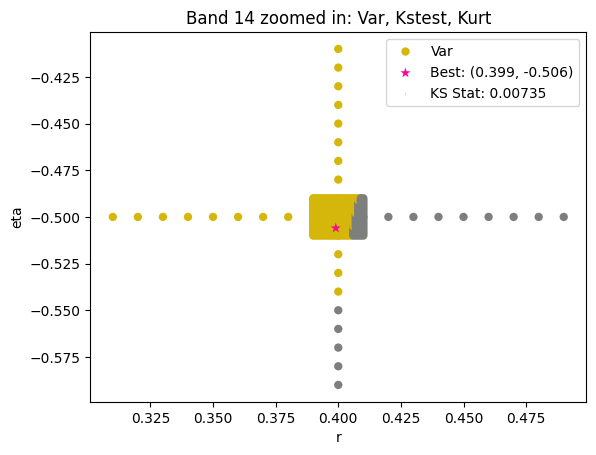

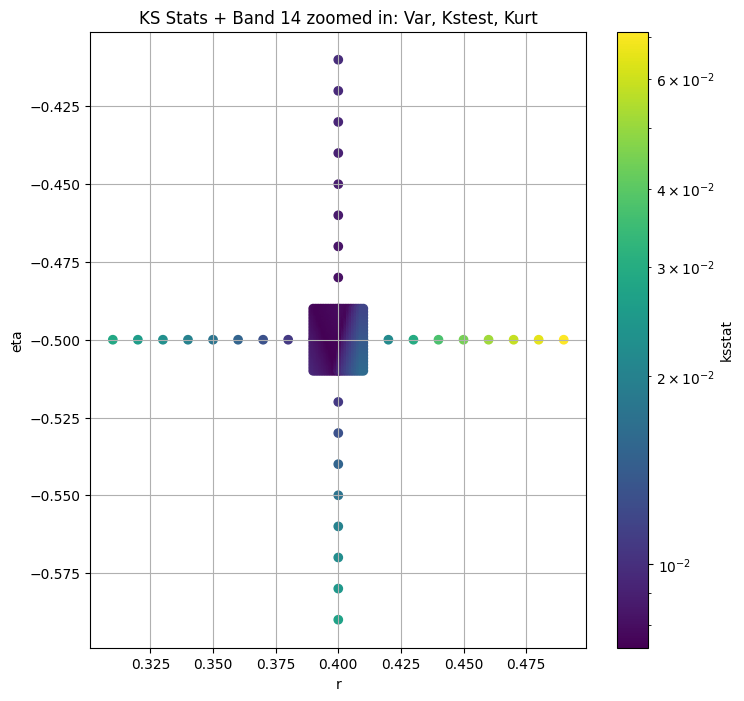

Band 17
(0.532, -0.61), 50 of 420
(0.534, -0.51), 100 of 420
(0.537, -0.61), 150 of 420
(0.539, -0.51), 200 of 420
(0.542, -0.61), 250 of 420
(0.544, -0.51), 300 of 420
(0.547, -0.61), 350 of 420
(0.549, -0.51), 400 of 420


100%|██████████| 420/420 [00:04<00:00, 84.61it/s] 


Finding Minimum after computing 420 CDFs
Iter 1 band 17 best parameters: ((0.537, -0.6), 0.0036174907315777993)


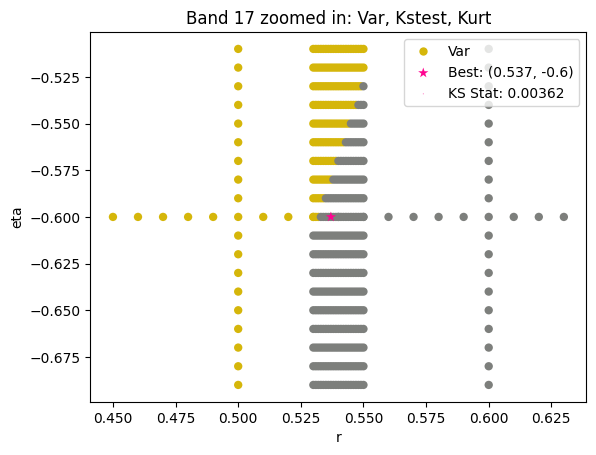

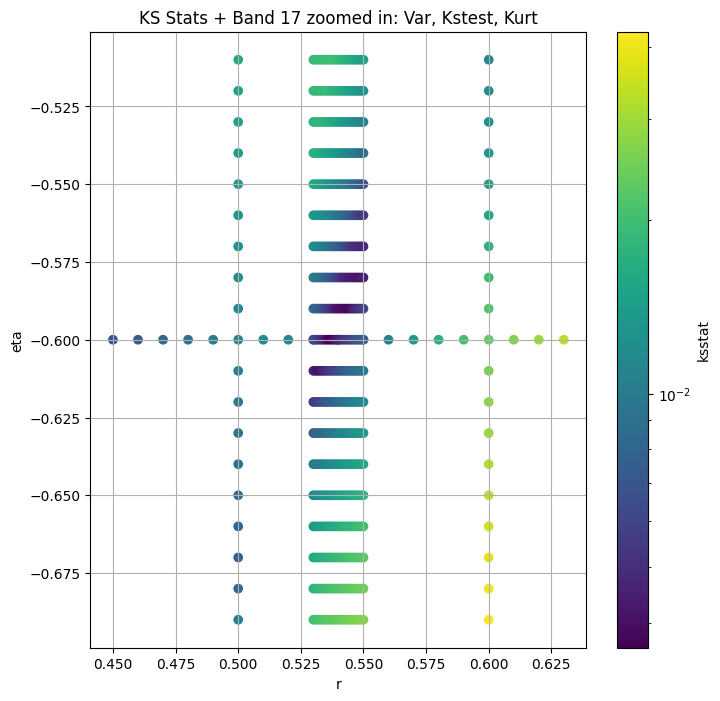

Band 20
(0.052, 6.19), 50 of 400
(0.054, 6.29), 100 of 400
(0.057, 6.19), 150 of 400
(0.059, 6.29), 200 of 400
(0.062, 6.19), 250 of 400
(0.064, 6.29), 300 of 400
(0.067, 6.19), 350 of 400
(0.069, 6.29), 400 of 400


c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 400/400 [00:04<00:00, 86.50it/s] 


Finding Minimum after computing 400 CDFs
Iter 1 band 20 best parameters: ((0.059, 6.29), 0.002093250134489022)


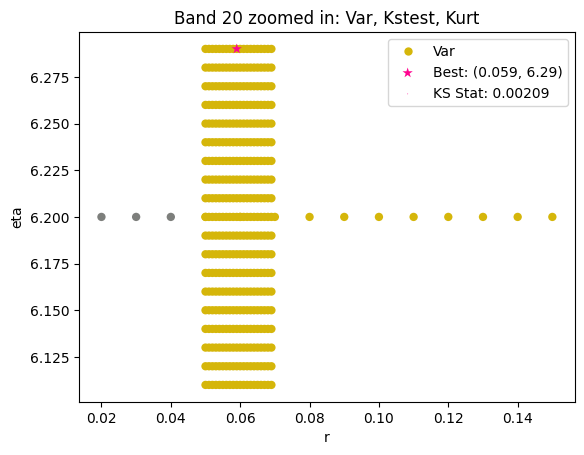

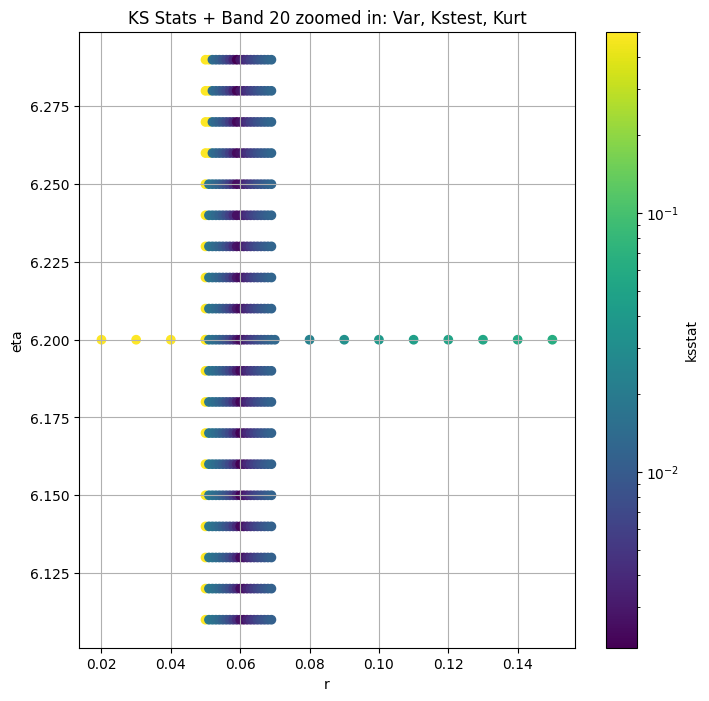

Band 23
(0.062, 7.39), 50 of 400
(0.064, 7.49), 100 of 400
(0.067, 7.39), 150 of 400
(0.069, 7.49), 200 of 400
(0.072, 7.39), 250 of 400
(0.074, 7.49), 300 of 400
(0.077, 7.39), 350 of 400
(0.079, 7.49), 400 of 400


c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 400/400 [00:04<00:00, 89.12it/s] 


Finding Minimum after computing 400 CDFs
Iter 1 band 23 best parameters: ((0.07, 7.41), 0.0020554462116563754)


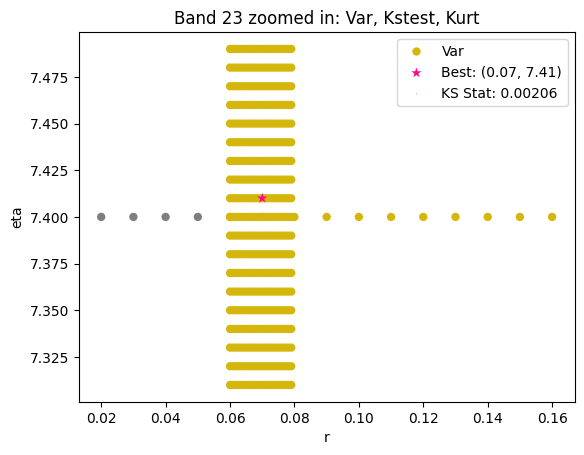

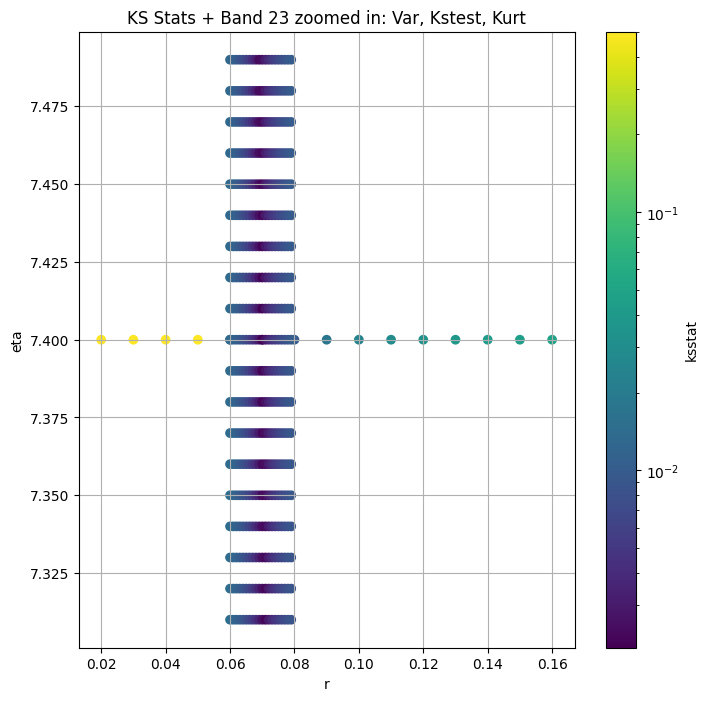

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,initial_scale,...,best_scale_eta0,kstest_stat_eta0,best_r,best_eta,best_scale,kstest_stat_best,iter1_r,iter1_eta,kstest_stat_iter1,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,,
2,2.108037e+08,1.960605e+08,2.266248e+08,5.938156,4.311651,8.405163,47614.0,0.27,0.5,6.990252e+04,...,199.297316,0.259215,0.274,0.470,8.719083e+04,0.012796,0.274,0.470,0.012796,11903
5,8.466665e+07,7.748904e+07,9.283818e+07,10.238721,6.227642,16.210068,102030.0,0.27,0.1,5.642633e+04,...,199.297316,0.182346,0.280,0.040,9.430047e+04,0.013075,0.280,0.040,0.013075,10759
8,2.441800e+07,2.231098e+07,2.684011e+07,10.654583,6.318540,24.114672,326496.0,0.30,-0.1,7.127441e+04,...,199.297316,0.078819,0.302,-0.108,7.706492e+04,0.011088,0.302,-0.108,0.011088,15304
11,6.095848e+06,5.591611e+06,6.651503e+06,9.481830,6.036284,16.780165,904666.0,0.35,-0.3,9.521702e+04,...,352.424126,0.013293,0.349,-0.310,9.506702e+04,0.009938,0.349,-0.310,0.009938,17887
14,1.795079e+06,1.641329e+06,1.980499e+06,11.123091,6.303249,29.718306,2727602.0,0.40,-0.5,9.942795e+04,...,1451.484833,0.014847,0.399,-0.506,9.919208e+04,0.007355,0.399,-0.506,0.007355,35958
17,4.415782e+05,3.955819e+05,5.499408e+05,38.040100,6.955561,230.069320,8298440.0,0.54,-0.6,1.000000e+05,...,6933.601867,0.019370,0.537,-0.600,1.000000e+05,0.003617,0.537,-0.600,0.003617,145870
20,7.319305e+04,6.264591e+04,1.226981e+05,212.946900,7.135597,983.588700,25140192.0,0.06,6.2,2.000461e-31,...,29682.030508,0.070616,0.059,6.290,3.114992e-32,0.002093,0.059,6.290,0.002093,441916
23,1.741782e+04,1.578904e+04,2.204838e+04,38.076736,4.879169,234.753980,65734528.0,0.07,7.4,7.356095e-27,...,29682.030508,0.175992,0.070,7.410,7.244688e-27,0.002055,0.070,7.410,0.002055,433306


In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=kstest_stat)
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

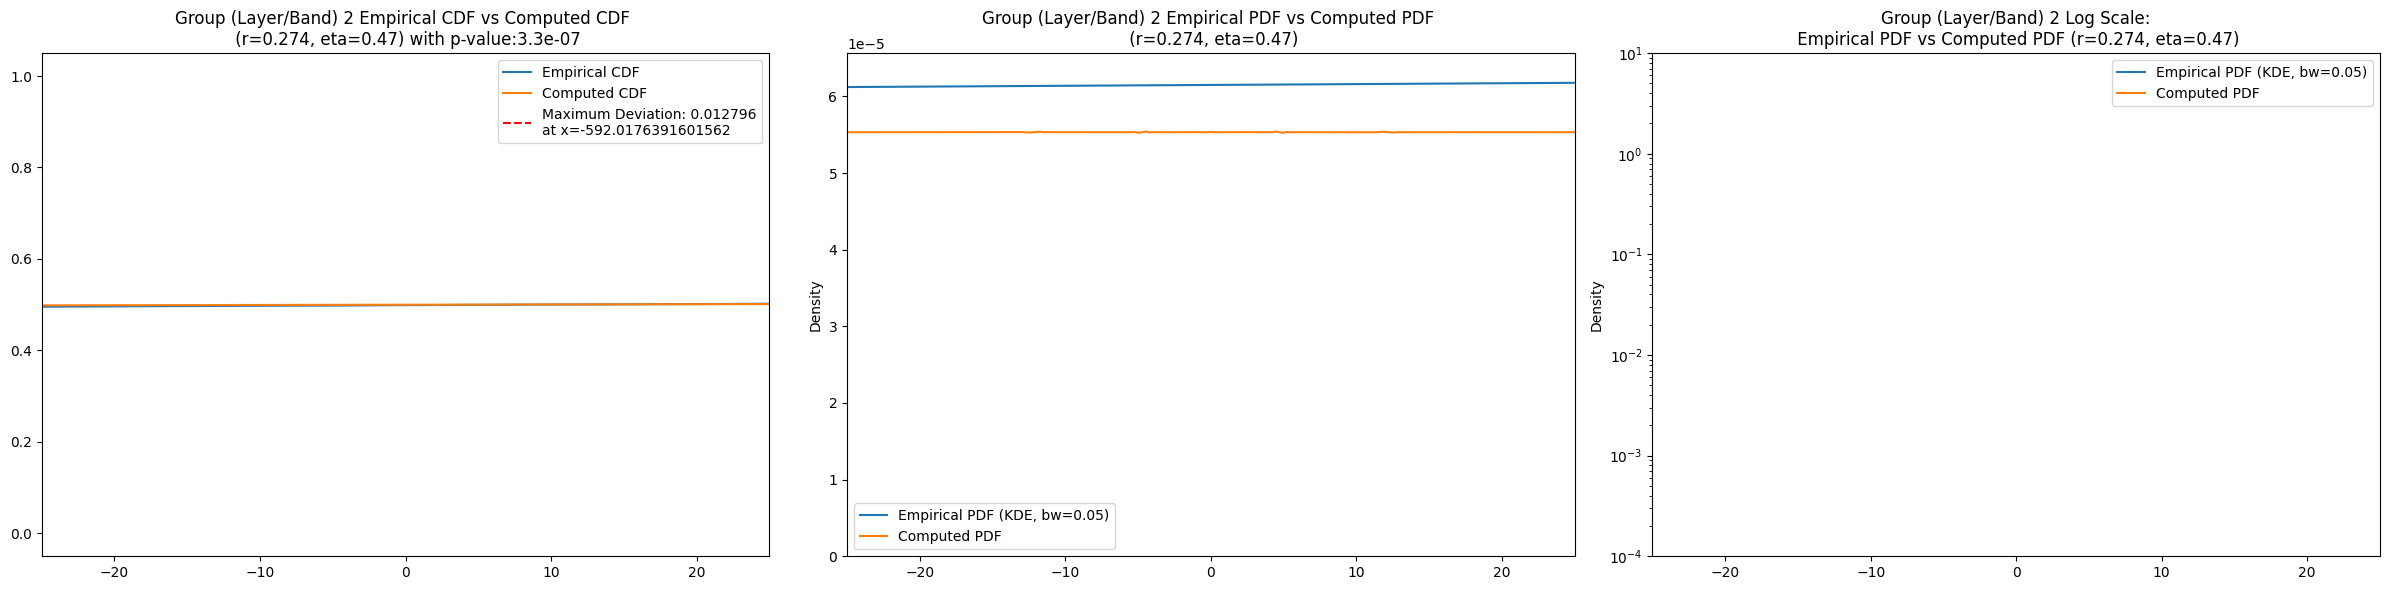

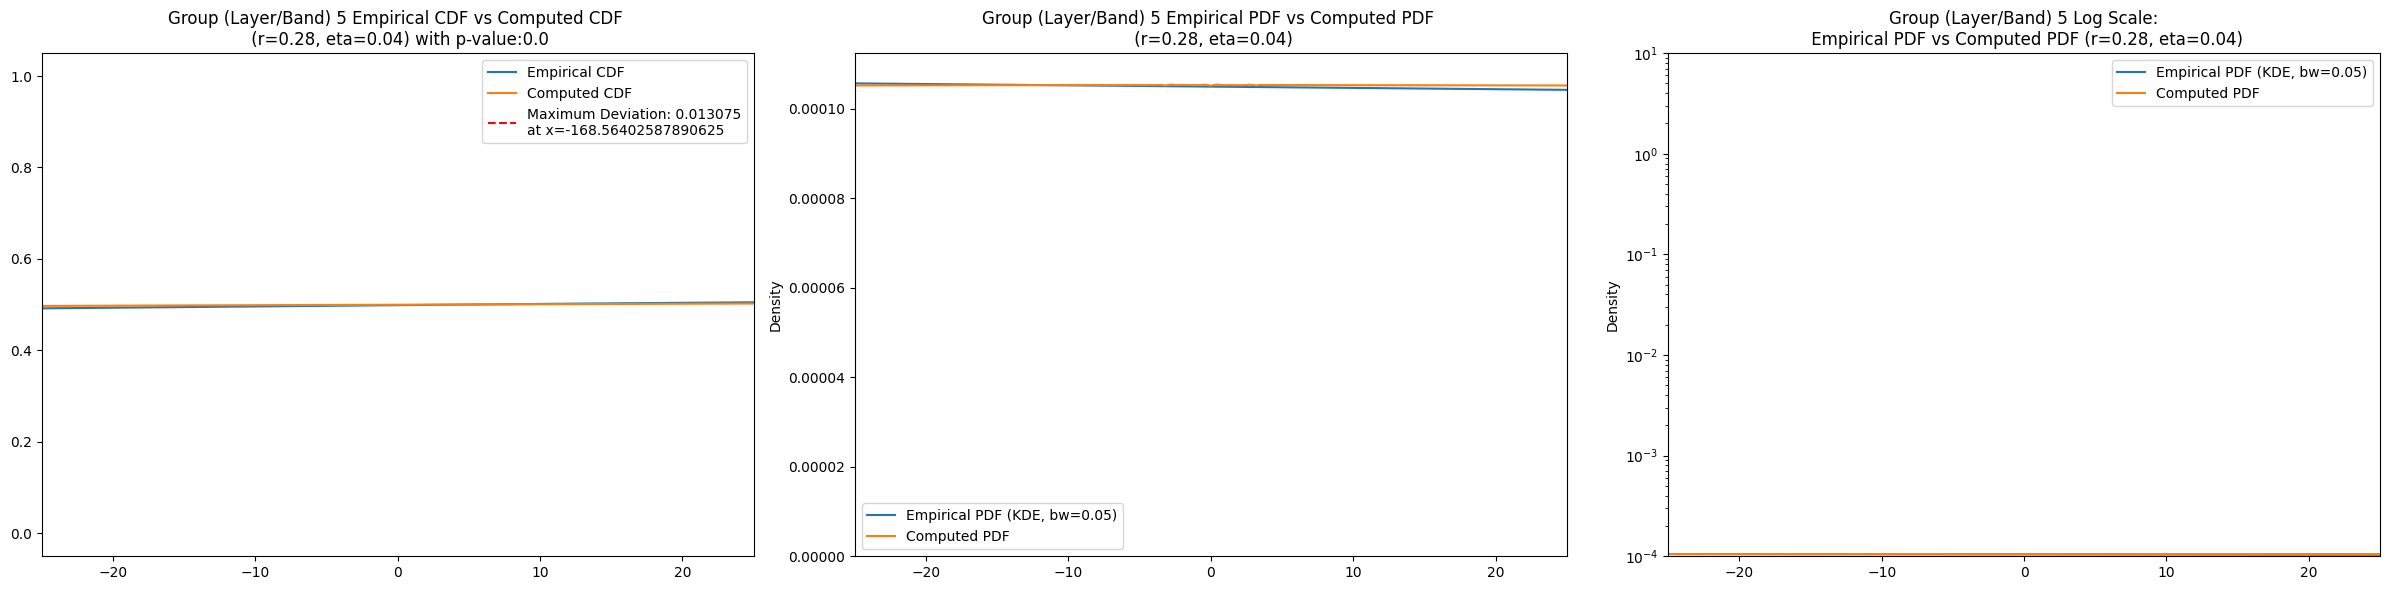

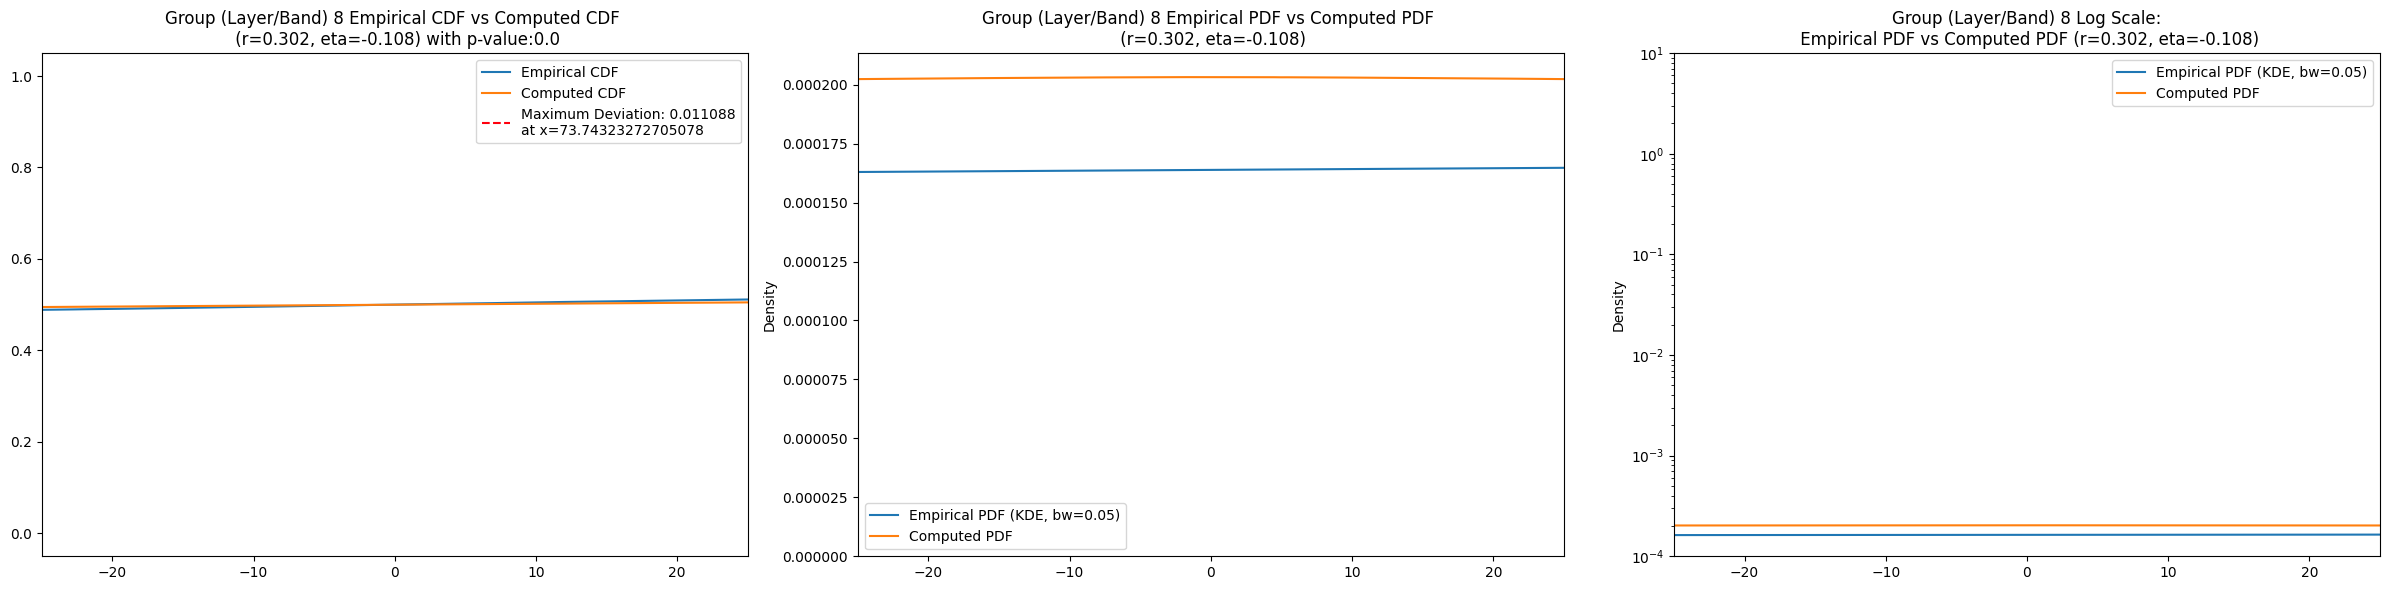

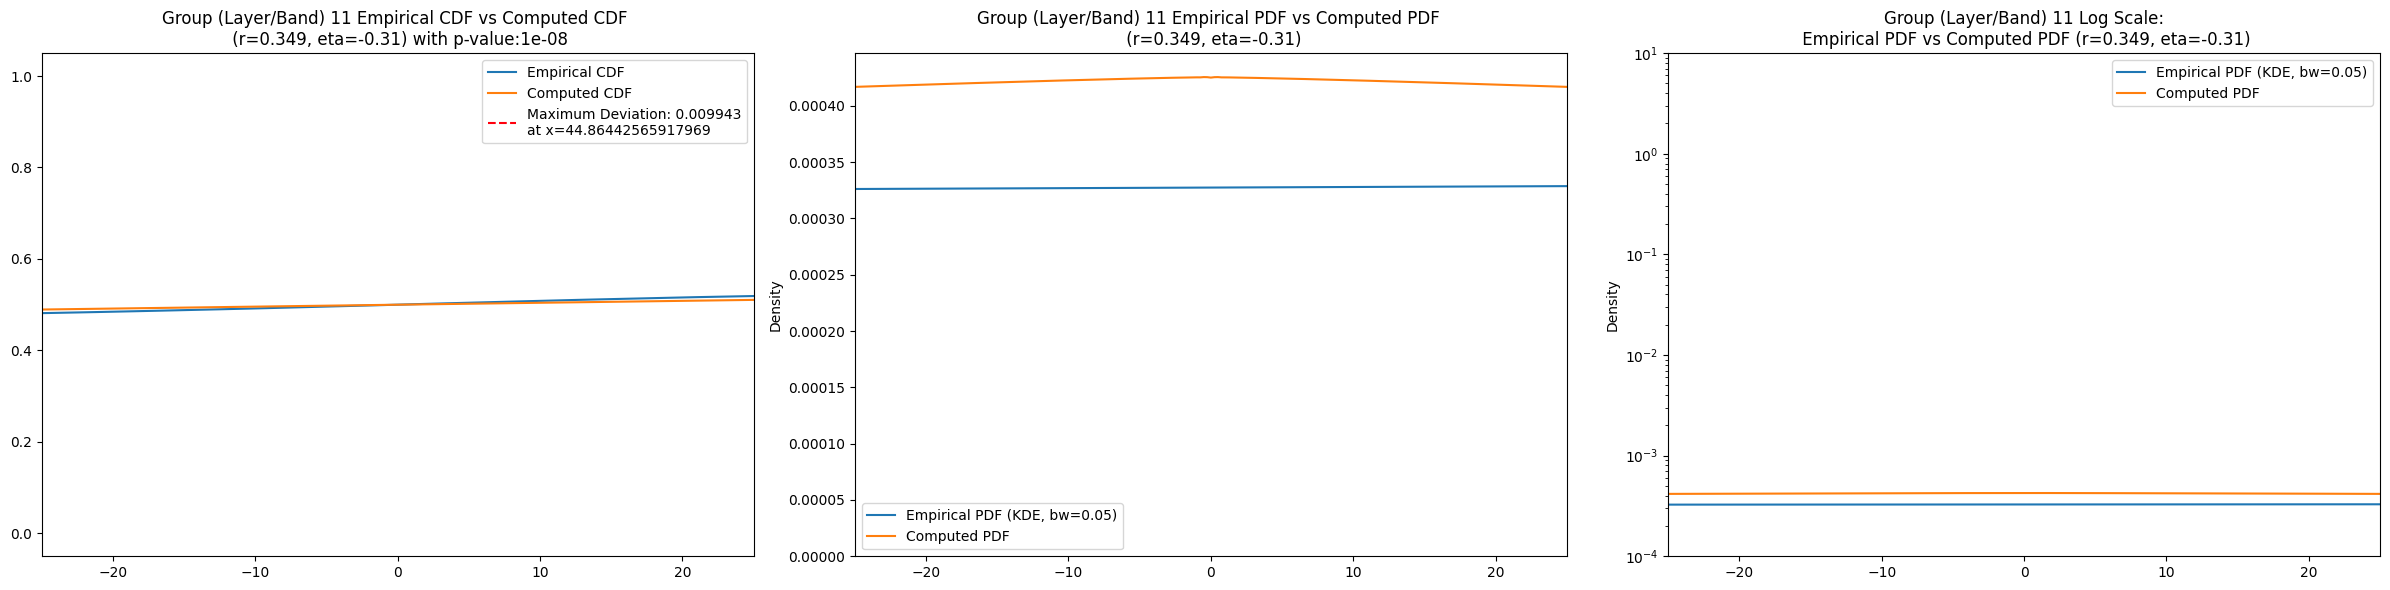

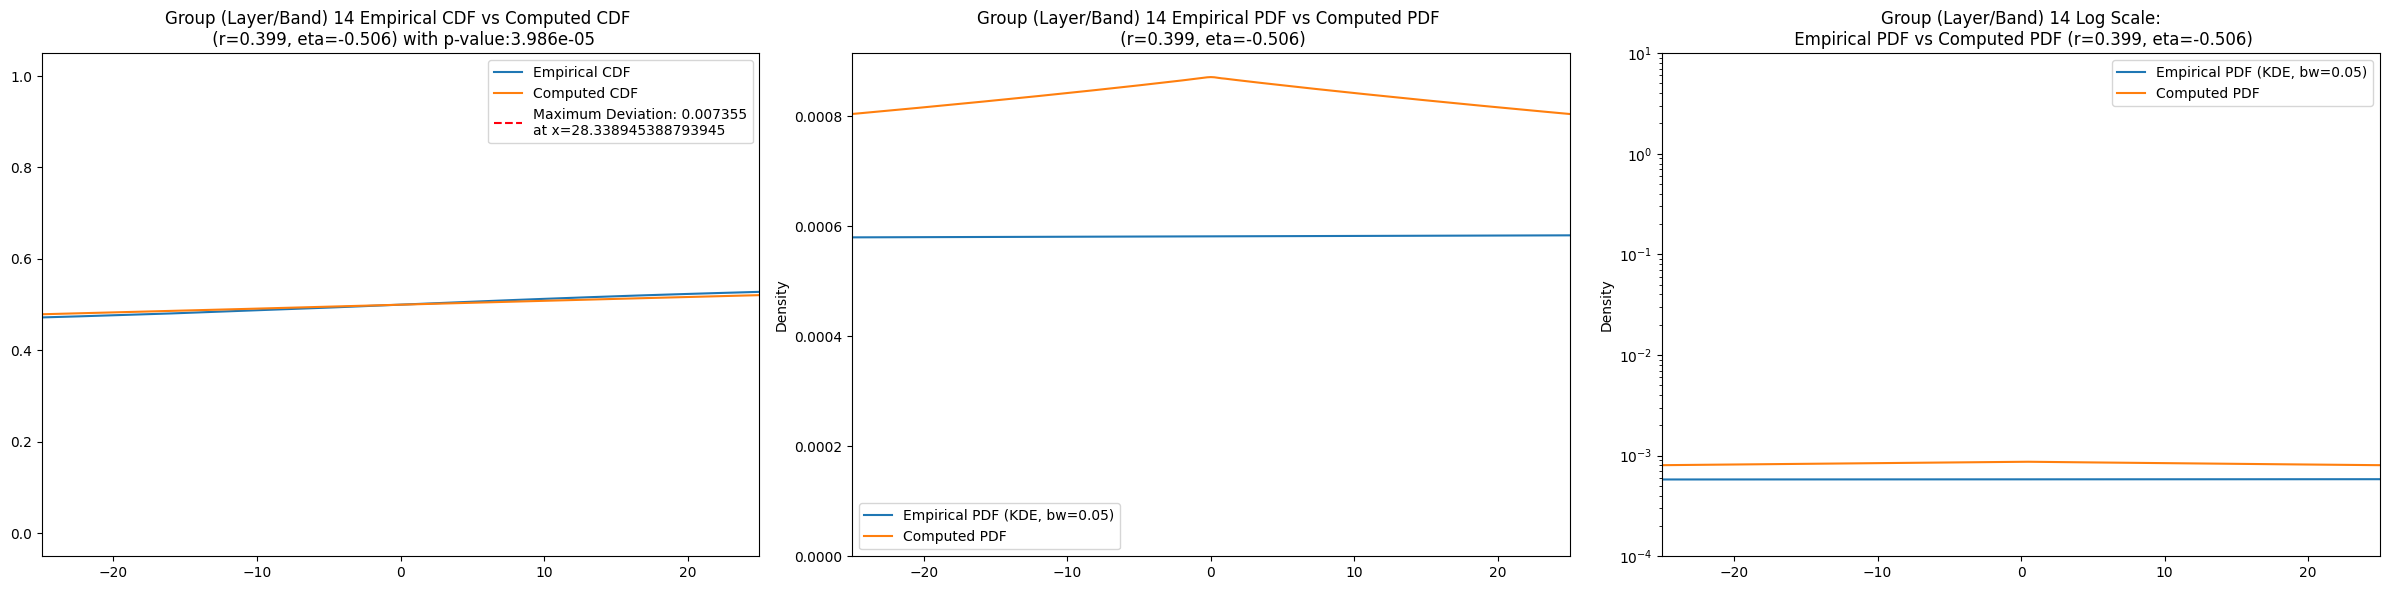

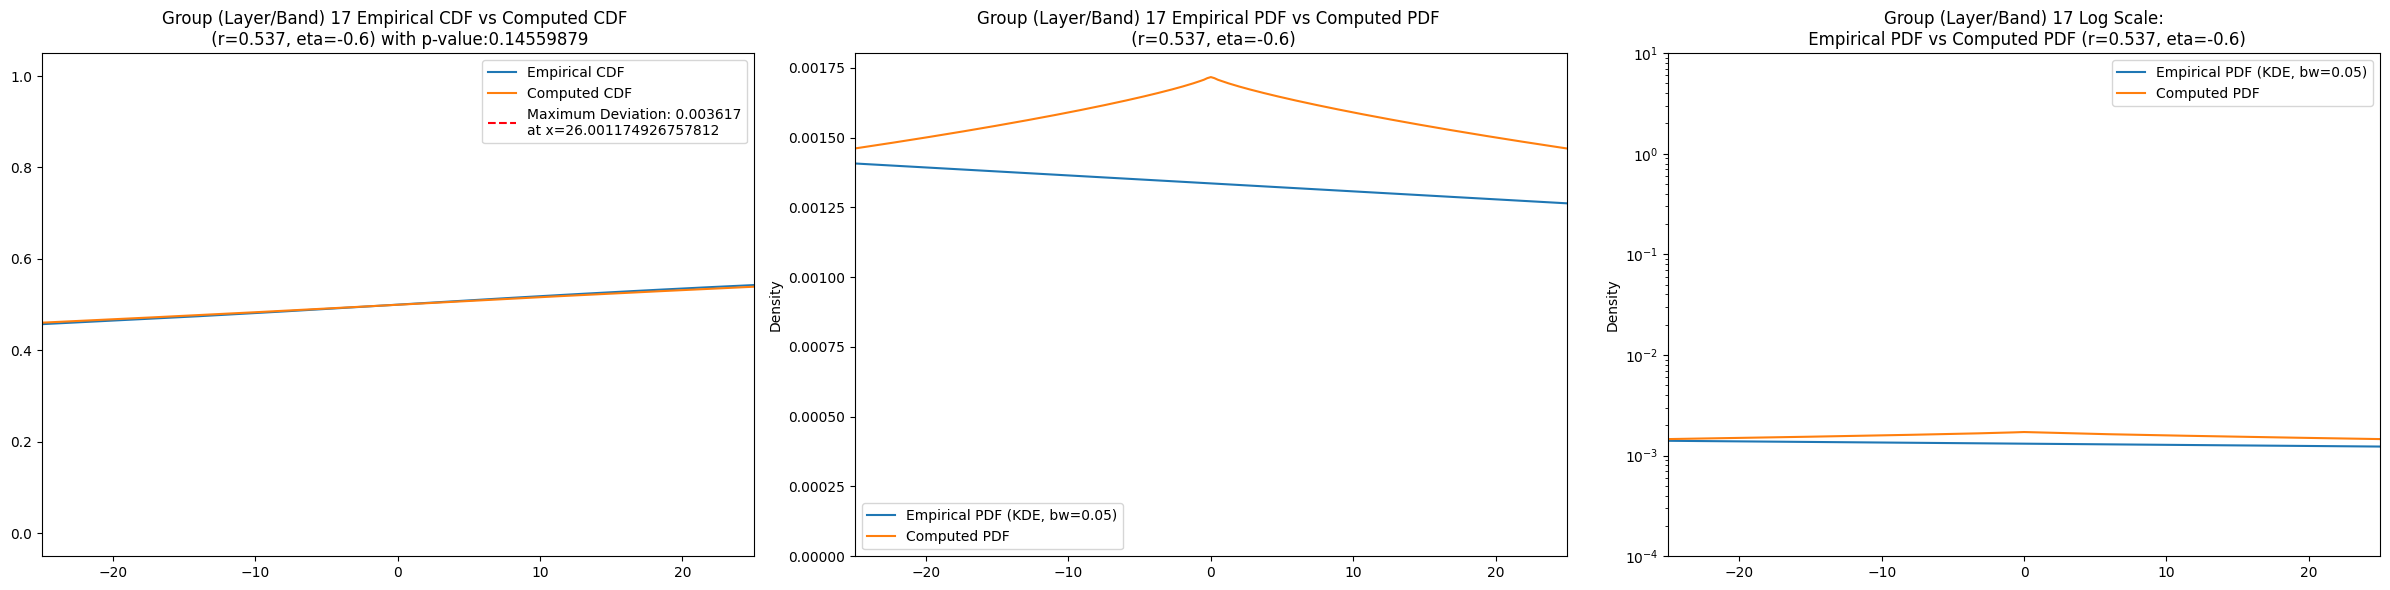

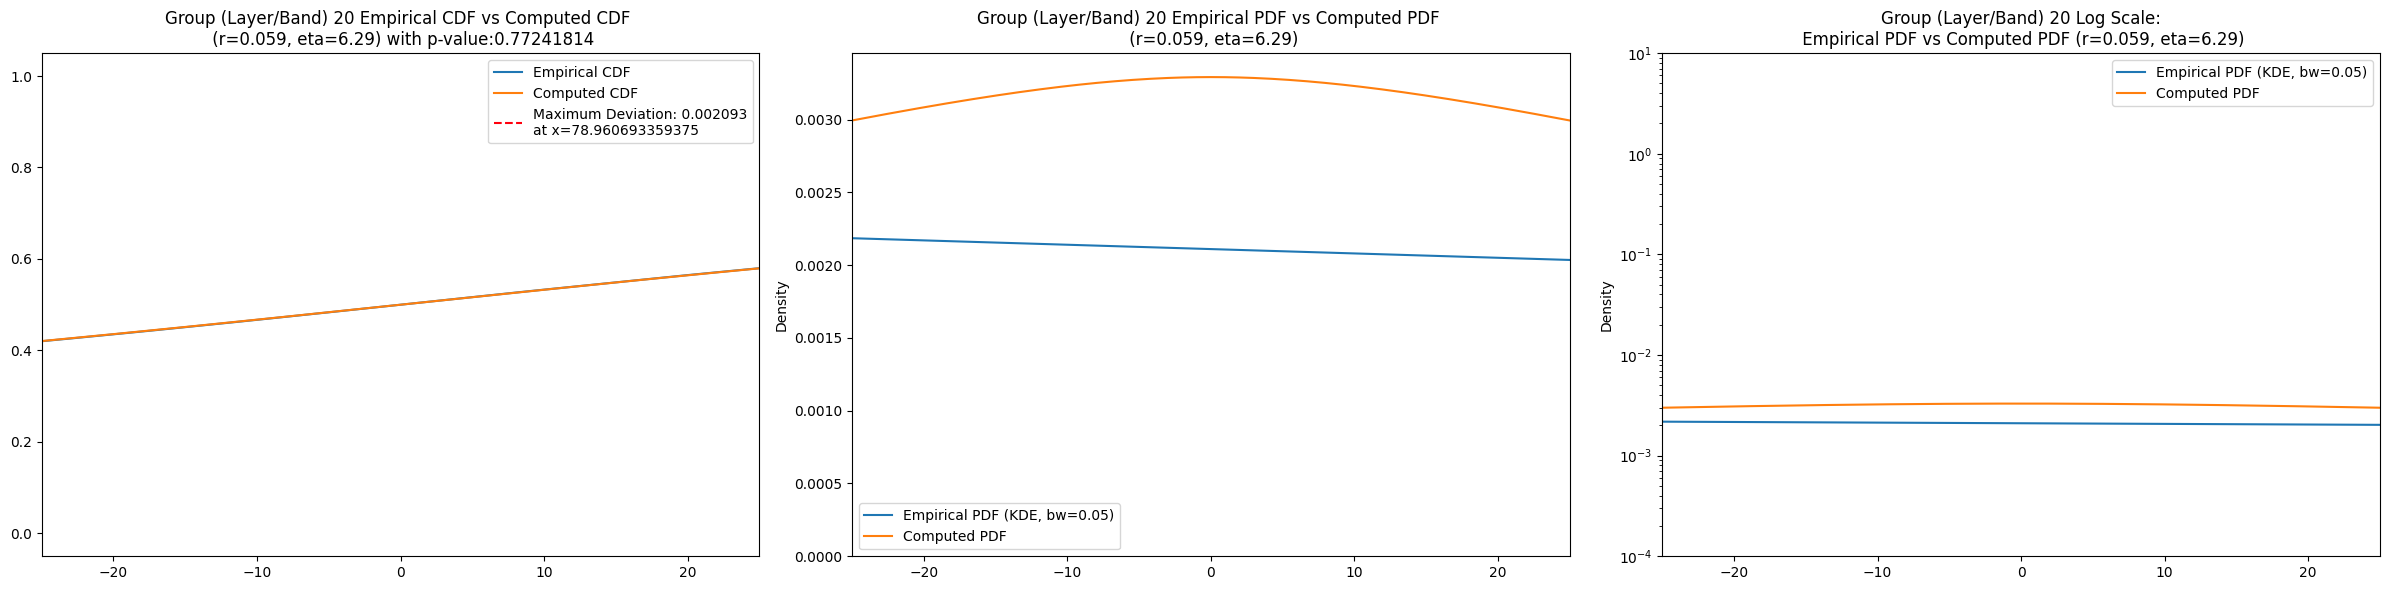

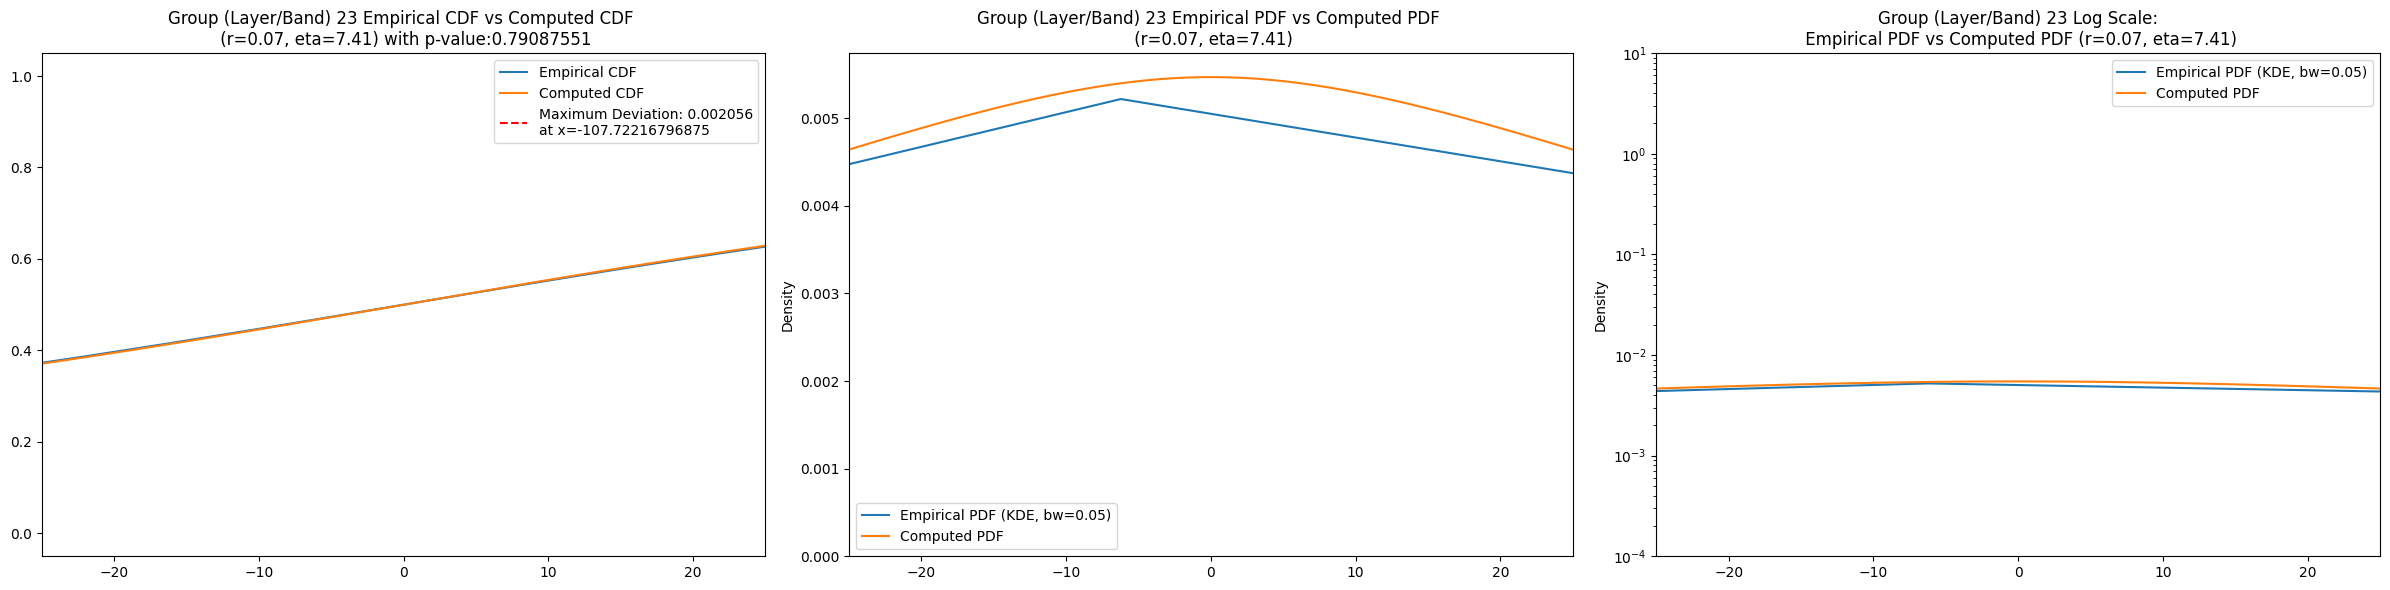

In [12]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [13]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [14]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,initial_scale,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,2.108037e+08,1.960605e+08,2.266248e+08,5.938156,4.311651,8.405163,47614.0,0.27,0.5,6.990252e+04,...,10620.5000,0.034521,9.809910e-50,8891.140,0.013030,1.883500e-07,7462.8300,0.017236,1.021520e-12,3.349751e-07
5,8.466665e+07,7.748904e+07,9.283818e+07,10.238721,6.227642,16.210068,102030.0,0.27,0.1,5.642633e+04,...,6275.7900,0.038255,3.589890e-130,5253.400,0.015208,6.296090e-21,4357.1100,0.018400,1.942210e-30,1.398044e-15
8,2.441800e+07,2.231098e+07,2.684011e+07,10.654583,6.318540,24.114672,326496.0,0.30,-0.1,7.127441e+04,...,3324.4700,0.038098,0.000000e+00,2835.020,0.013518,2.969630e-52,2302.6600,0.016280,1.333100e-75,2.691388e-35
11,6.095848e+06,5.591611e+06,6.651503e+06,9.481830,6.036284,16.780165,904666.0,0.35,-0.3,9.521702e+04,...,1663.7600,0.038488,0.000000e+00,1425.200,0.013782,1.098330e-149,1146.0300,0.016450,4.506960e-213,4.849325e-78
14,1.795079e+06,1.641329e+06,1.980499e+06,11.123091,6.303249,29.718306,2727602.0,0.40,-0.5,9.942795e+04,...,875.1990,0.041127,0.000000e+00,766.911,0.014576,0.000000e+00,601.7750,0.017202,0.000000e+00,1.407257e-128
17,4.415782e+05,3.955819e+05,5.499408e+05,38.040100,6.955561,230.069320,8298440.0,0.54,-0.6,1.000000e+05,...,428.4130,0.040088,0.000000e+00,378.102,0.013210,0.000000e+00,295.8030,0.015692,0.000000e+00,9.445872e-95
20,7.319305e+04,6.264591e+04,1.226981e+05,212.946900,7.135597,983.588700,25140192.0,0.06,6.2,2.000461e-31,...,174.7300,0.036870,0.000000e+00,154.155,0.010881,0.000000e+00,122.9310,0.009767,0.000000e+00,4.164336e-96
23,1.741782e+04,1.578904e+04,2.204838e+04,38.076736,4.879169,234.753980,65734528.0,0.07,7.4,7.356095e-27,...,96.1868,0.030878,0.000000e+00,83.447,0.006637,0.000000e+00,68.1502,0.005127,0.000000e+00,1.193086e-241


## Results

In [15]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [16]:
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,initial_scale,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,2.108037e+08,1.960605e+08,2.266248e+08,5.938156,4.311651,8.405163,47614.0,0.27,0.5,6.990252e+04,...,10620.5000,0.034521,9.809910e-50,8891.140,0.013030,1.883500e-07,7462.8300,0.017236,1.021520e-12,3.349751e-07
5,8.466665e+07,7.748904e+07,9.283818e+07,10.238721,6.227642,16.210068,102030.0,0.27,0.1,5.642633e+04,...,6275.7900,0.038255,3.589890e-130,5253.400,0.015208,6.296090e-21,4357.1100,0.018400,1.942210e-30,1.398044e-15
8,2.441800e+07,2.231098e+07,2.684011e+07,10.654583,6.318540,24.114672,326496.0,0.30,-0.1,7.127441e+04,...,3324.4700,0.038098,0.000000e+00,2835.020,0.013518,2.969630e-52,2302.6600,0.016280,1.333100e-75,2.691388e-35
11,6.095848e+06,5.591611e+06,6.651503e+06,9.481830,6.036284,16.780165,904666.0,0.35,-0.3,9.521702e+04,...,1663.7600,0.038488,0.000000e+00,1425.200,0.013782,1.098330e-149,1146.0300,0.016450,4.506960e-213,4.849325e-78
14,1.795079e+06,1.641329e+06,1.980499e+06,11.123091,6.303249,29.718306,2727602.0,0.40,-0.5,9.942795e+04,...,875.1990,0.041127,0.000000e+00,766.911,0.014576,0.000000e+00,601.7750,0.017202,0.000000e+00,1.407257e-128
17,4.415782e+05,3.955819e+05,5.499408e+05,38.040100,6.955561,230.069320,8298440.0,0.54,-0.6,1.000000e+05,...,428.4130,0.040088,0.000000e+00,378.102,0.013210,0.000000e+00,295.8030,0.015692,0.000000e+00,9.445872e-95
20,7.319305e+04,6.264591e+04,1.226981e+05,212.946900,7.135597,983.588700,25140192.0,0.06,6.2,2.000461e-31,...,174.7300,0.036870,0.000000e+00,154.155,0.010881,0.000000e+00,122.9310,0.009767,0.000000e+00,4.164336e-96
23,1.741782e+04,1.578904e+04,2.204838e+04,38.076736,4.879169,234.753980,65734528.0,0.07,7.4,7.356095e-27,...,96.1868,0.030878,0.000000e+00,83.447,0.006637,0.000000e+00,68.1502,0.005127,0.000000e+00,1.193086e-241


In [17]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))

PermissionError: [WinError 5] Access is denied: 'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\spaceNet\\fourier\\approx1e5\\gray\\groupCDFs\\band11'